In [32]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, recall_score, f1_score, average_precision_score

from scipy import interp
from xgboost import XGBClassifier

from database.utils import get_train_test_data
from pipelines.feature_extractor import get_feature_extractor
from pipelines.models import get_ensemble_model
from feature_extraction.features import get_glove_w2v
from evaluation.metrics import *

from copy import deepcopy
import numpy as np
import pandas as pd
import pprint
import time

import matplotlib.pyplot as plt
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
w2v = get_glove_w2v()
feature_extractor = get_feature_extractor(w2v)

In [29]:
ensemble = get_ensemble_model(w2v)
ensemble.steps = ensemble.steps[2:]

In [17]:
cols_target = ['label_pa', 'label_sb', 'label_sleep']
print('Total rows in test is {}'.format(len(X_test)))
print('Total rows in train is {}'.format(len(X_train)))
print(y_train[cols_target].sum())

Total rows in test is 2213
Total rows in train is 8070
label_pa       1259.0
label_sb       1535.0
label_sleep     411.0
dtype: float64


## Multilabel

In [30]:
Xr_train, y_train, Xr_test, y_test = get_train_test_data(merge=True)

models = [("lr", OneVsRestClassifier(LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1))),
          ("nb", OneVsRestClassifier(BernoulliNB(alpha=5.0))),
          ("rf", OneVsRestClassifier(RandomForestClassifier(n_estimators=300, 
                                                            max_depth=10,
                                                            min_samples_split=5,
                                                            n_jobs=-1))),
          ("xgb", OneVsRestClassifier(XGBClassifier(n_estimators=150,
                                                    max_depth=8,
                                                    n_jobs=8))),
          ("et", OneVsRestClassifier(ExtraTreesClassifier(n_estimators=300,
                                                          max_depth=10,
                                                          min_samples_split=10,
                                                          n_jobs=-1))),
          ("ensemble", OneVsRestClassifier(ensemble)),
           #("svm", SVC(C=100, gamma=0.0001, probability=True)),
         ]

results = {}

X_train = feature_extractor.fit_transform(Xr_train, y_train['label_pa'])
X_test = feature_extractor.transform(Xr_test)

for name, classifier in models:
    print(name)
    results[name] = {}

    cv = StratifiedKFold(n_splits=5, random_state=42)
    
    train_times = []
    predict_times = []
        
    ts = time.time()
    classifier.fit(X_train, y_train)
    te = time.time()
    train_times.append(te - ts)
    
    y_scores_test = classifier.predict_proba(X_test)
    ts = time.time()
    y_pred_test = classifier.predict(X_test)
    te = time.time()
    predict_times.append(te - ts)
    
    measures, tpr, fpr, roc_auc = class_report_multilabel(y_test, y_scores_test)
    for metric in measures:
        results[name][metric] = measures[metric]
        
    results[name]['train_time'] = np.mean(train_times)
    results[name]['predict_time'] = np.mean(predict_times)

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f30def12b70, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda3/envs/carnd-term1/lib/python3.5/si...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f30def12b70, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/opt/anaconda3/envs/carnd-term1/lib/python3.5/si...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/opt/anacond.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    648 
    649         If a global instance already exists, this reinitializes and starts it
    650         """
    651         app = cls.instance(**kwargs)
    652         app.initialize(argv)
--> 653         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    654 
    655 #-----------------------------------------------------------------------------
    656 # utility functions, for convenience
    657 #-----------------------------------------------------------------------------

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-25T18:29:40.331674', 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'session': 'E38253EF3E4A443282A0E601C9FF2E73', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'E38253EF3E4A443282A0E601C9FF2E73']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-25T18:29:40.331674', 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'session': 'E38253EF3E4A443282A0E601C9FF2E73', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'E38253EF3E4A443282A0E601C9FF2E73'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2018-05-25T18:29:40.331674', 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'session': 'E38253EF3E4A443282A0E601C9FF2E73', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '59A99A496E314ABBB1E55A05AA114A32', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)",), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)",)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-30-e9299962278e>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f30756c8e80, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f307fab59c0, file "<ipython-input-30-e9299962278e>", line 22>
        result = <ExecutionResult object at 7f30756c8e80, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f307fab59c0, file "<ipython-input-30-e9299962278e>", line 22>, result=<ExecutionResult object at 7f30756c8e80, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f307fab59c0, file "<ipython-input-30-e9299962278e>", line 22>
        self.user_global_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'Callback': <class 'keras.callbacks.Callback'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('cd ..')", "from sklearn.model_selection import cross_val_sc... autoreload')\nget_ipython().magic('autoreload 2')", "from sklearn.model_selection import cross_val_sc... autoreload')\nget_ipython().magic('autoreload 2')", 'w2v = get_glove_w2v()\nfeature_extractor = get_feature_extractor(w2v)', 'ensemble = get_ensemble_model(w2v)\nensemble.steps = ensemble.steps[2:]', "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", 'pd.DataFrame(results).T', 'lw = 2\n\n# First aggregate all false positive rat...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'y_train', 'np.where(y_train)', 'np.unique(np.where(y_train)[1])', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'y_test', 'y_test[:, 2]', 'y_test.values[:, 2]', 'y_sleep = y_test.values[:, 2]\ny_pred_sleep = y_pred_test[:, 2]', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {8:           accuracy  avg_precision   f1score  pre... 21.863904  
xgb           0.934096   86.448091  , 10:       label_pa  label_sb  label_sleep
0         ...0       0.0          0.0

[8070 rows x 3 columns], 11: (array([   0,    1,    2, ..., 8065, 8067, 8068]), array([2, 2, 2, ..., 0, 0, 0])), 12: array([0, 1, 2]), 16:       label_pa  label_sb  label_sleep
0         ...0       0.0          0.0

[2213 rows x 3 columns], 18: array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), 21: array([130, 132, 135, 138, 156, 161, 176, 187, 202, 207, 212, 218, 223,
       224, 230]), 22: (15, 59), 23: 74, 25: {'accuracy': 0.77586985991866242, 'avg_precision': 0.72043273227083204, 'f1score': 0.63274336283185828, 'precision': 0.778584392014519, 'recall': 0.53291925465838508, 'sensitivity': 0.5329192546583851, 'specificity': 0.9790881042166609, 'test_roc_auc': 0.93280821615137233}, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RocAucEvaluation': <class 'evaluation.metrics.RocAucEvaluation'>, ...}
        self.user_ns = {'BernoulliNB': <class 'sklearn.naive_bayes.BernoulliNB'>, 'Callback': <class 'keras.callbacks.Callback'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "get_ipython().magic('cd ..')", "from sklearn.model_selection import cross_val_sc... autoreload')\nget_ipython().magic('autoreload 2')", "from sklearn.model_selection import cross_val_sc... autoreload')\nget_ipython().magic('autoreload 2')", 'w2v = get_glove_w2v()\nfeature_extractor = get_feature_extractor(w2v)', 'ensemble = get_ensemble_model(w2v)\nensemble.steps = ensemble.steps[2:]', "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", "Xr_train, y_train, Xr_test, y_test = get_train_t...ts[name]['predict_time'] = np.mean(predict_times)", 'pd.DataFrame(results).T', 'lw = 2\n\n# First aggregate all false positive rat...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'y_train', 'np.where(y_train)', 'np.unique(np.where(y_train)[1])', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'lw = 2\nn_classes = 3\n\n# First aggregate all fals...-class\')\nplt.legend(loc="lower right")\nplt.show()', 'y_test', 'y_test[:, 2]', 'y_test.values[:, 2]', 'y_sleep = y_test.values[:, 2]\ny_pred_sleep = y_pred_test[:, 2]', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {8:           accuracy  avg_precision   f1score  pre... 21.863904  
xgb           0.934096   86.448091  , 10:       label_pa  label_sb  label_sleep
0         ...0       0.0          0.0

[8070 rows x 3 columns], 11: (array([   0,    1,    2, ..., 8065, 8067, 8068]), array([2, 2, 2, ..., 0, 0, 0])), 12: array([0, 1, 2]), 16:       label_pa  label_sb  label_sleep
0         ...0       0.0          0.0

[2213 rows x 3 columns], 18: array([ 1.,  1.,  1., ...,  0.,  0.,  0.]), 21: array([130, 132, 135, 138, 156, 161, 176, 187, 202, 207, 212, 218, 223,
       224, 230]), 22: (15, 59), 23: 74, 25: {'accuracy': 0.77586985991866242, 'avg_precision': 0.72043273227083204, 'f1score': 0.63274336283185828, 'precision': 0.778584392014519, 'recall': 0.53291925465838508, 'sensitivity': 0.5329192546583851, 'specificity': 0.9790881042166609, 'test_roc_auc': 0.93280821615137233}, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RocAucEvaluation': <class 'evaluation.metrics.RocAucEvaluation'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/vmadmin/pass/<ipython-input-30-e9299962278e> in <module>()
     17            #("svm", SVC(C=100, gamma=0.0001, probability=True)),
     18          ]
     19 
     20 results = {}
     21 
---> 22 X_train = feature_extractor.fit_transform(Xr_train, y_train['label_pa'])
     23 X_test = feature_extractor.transform(Xr_test)
     24 
     25 for name, classifier in models:
     26     print(name)

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py in fit_transform(self=Pipeline(memory=None,
     steps=[('feature_extr...e_func=<function f_classif at 0x7f30a6e21598>))]), X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64, **fit_params={})
    276         -------
    277         Xt : array-like, shape = [n_samples, n_transformed_features]
    278             Transformed samples
    279         """
    280         last_step = self._final_estimator
--> 281         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N..._func=<function f_classif at 0x7f30a6e21598>))])>
        X = 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object
        y = 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64
    282         if hasattr(last_step, 'fit_transform'):
    283             return last_step.fit_transform(Xt, y, **fit_params)
    284         elif last_step is None:
    285             return Xt

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('feature_extr...e_func=<function f_classif at 0x7f30a6e21598>))]), X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'feature_extraction': {}, 'feature_selection': {}}
        name = 'feature_extraction'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7f309af7d8c8>), *args=(FeatureUnion(n_jobs=-1,
       transformer_list=...7f30753897f0>)],
       transformer_weights=None), None, 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (FeatureUnion(n_jobs=-1,
       transformer_list=...7f30753897f0>)],
       transformer_weights=None), None, 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=FeatureUnion(n_jobs=-1,
       transformer_list=...7f30753897f0>)],
       transformer_weights=None), weight=None, X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method FeatureUnion.fit_transform of Feat...f30753897f0>)],
       transformer_weights=None)>
        X = 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object
        y = 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py in fit_transform(self=FeatureUnion(n_jobs=-1,
       transformer_list=...7f30753897f0>)],
       transformer_weights=None), X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64, **fit_params={})
    734         """
    735         self._validate_transformers()
    736         result = Parallel(n_jobs=self.n_jobs)(
    737             delayed(_fit_transform_one)(trans, weight, X, y,
    738                                         **fit_params)
--> 739             for name, trans, weight in self._iter())
        self._iter = <bound method FeatureUnion._iter of FeatureUnion...f30753897f0>)],
       transformer_weights=None)>
    740 
    741         if not result:
    742             # All transformers are None
    743             return np.zeros((X.shape[0], 0))

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object FeatureUnion.fit_transform.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Fri May 25 18:32:06 2018
PID: 25628         Python 3.5.2: /opt/anaconda3/envs/carnd-term1/bin/python
...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_transform_one>, (<feature_extraction.transformers.TfidfEmbeddingVectorizer object>, None, 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_transform_one>
        args = (<feature_extraction.transformers.TfidfEmbeddingVectorizer object>, None, 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=<feature_extraction.transformers.TfidfEmbeddingVectorizer object>, weight=None, X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64, **fit_params={})
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
    581         res = transformer.fit_transform(X, y, **fit_params)
    582     else:
--> 583         res = transformer.fit(X, y, **fit_params).transform(X)
        res = undefined
        transformer.fit = <bound method TfidfEmbeddingVectorizer.fit of <f...on.transformers.TfidfEmbeddingVectorizer object>>
        X = 0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object
        y = 0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64
        fit_params.transform = undefined
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:
    586         return res, transformer
    587     return res * weight, transformer

...........................................................................
/home/vmadmin/pass/feature_extraction/transformers.py in fit(self=<feature_extraction.transformers.TfidfEmbeddingVectorizer object>, X=0       night windsor . thanks for the fun . yes...g .
Name: clean_text, Length: 8070, dtype: object, y=0       0.0
1       0.0
2       0.0
3       0.0
... 0.0
Name: label_pa, Length: 8070, dtype: float64)
    148                                     )
    149         #self.tfidf.fit(X)
    150         # if a word was never seen - it must be at least as infrequent
    151         # as any of the known words - so the default idf is the max of
    152         # known idf's
--> 153         max_idf = max(self.tfidf.idf_)
        self.tfidf.idf_ = undefined
    154         self.word2weight = defaultdict(
    155             lambda: max_idf,
    156             [(w, self.tfidf.idf_[i]) for w, i in self.tfidf.vocabulary_.items()])
    157 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in idf_(self=TfidfVectorizer(analyzer='word', binary=False, d...e0264a8>>,
        use_idf=True, vocabulary=None))
   1342     def sublinear_tf(self, value):
   1343         self._tfidf.sublinear_tf = value
   1344 
   1345     @property
   1346     def idf_(self):
-> 1347         return self._tfidf.idf_
        self._tfidf.idf_ = undefined
   1348 
   1349     def fit(self, raw_documents, y=None):
   1350         """Learn vocabulary and idf from training set.
   1351 

...........................................................................
/opt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/feature_extraction/text.py in idf_(self=TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True))
   1117 
   1118     @property
   1119     def idf_(self):
   1120         # if _idf_diag is not set, this will raise an attribute error,
   1121         # which means hasattr(self, "idf_") is False
-> 1122         return np.ravel(self._idf_diag.sum(axis=0))
        self._idf_diag.sum = undefined
   1123 
   1124 
   1125 class TfidfVectorizer(CountVectorizer):
   1126     """Convert a collection of raw documents to a matrix of TF-IDF features.

AttributeError: 'TfidfTransformer' object has no attribute '_idf_diag'
___________________________________________________________________________

In [24]:
measures, tpr, fpr, roc_auc = class_report_multilabel(y_test, y_scores_test)

ROC AUC for class 0: 0.97
Precision for class 0: 0.85
ROC AUC for class 1: 0.89
Precision for class 1: 0.68
ROC AUC for class 2: 0.98
Precision for class 2: 0.79
Average precision score, micro-averaged over all classes: 0.72
Test score: 0.93



In [31]:
pd.DataFrame(results).T

""


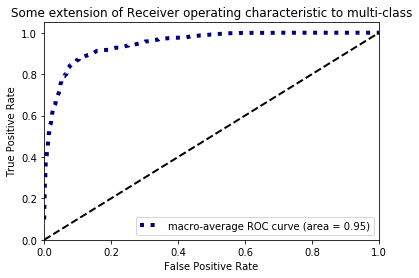

In [15]:
lw = 2
n_classes = 3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

roc_auc = dict()
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Separating each indicator

In [37]:
%%time

train_test_data = get_train_test_data()

models = [("lr", LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1)),
           ("nb", BernoulliNB(alpha=5.0)),
           ("rf", RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, n_jobs=-1)),
           #("xgb", XGBClassifier(n_estimators=300, max_depth=8, n_jobs=-1)),
           #("et", ExtraTreesClassifier(n_estimators=300, max_depth=10, min_samples_split=10, n_jobs=-1)),
           #("svm", SVC(C=100, gamma=0.0001, probability=True)),
           #("ensemble", ensemble),
           #("nbsvm", )
         ]

results = {}

for Xr_train, y_train, Xr_test, y_test, indicator in train_test_data:
    X_train = feature_extractor.fit_transform(Xr_train, y_train)
    X_test = feature_extractor.transform(Xr_test)
            
    print(indicator, X_train.shape)
    
    results[indicator] = {}
    for name, classifier in models:
        results[indicator][name] = {}
        
        cv = StratifiedKFold(n_splits=5, random_state=42)
        scores = []
        conf_mat = np.zeros((2, 2))      # Binary classification
        false_pos = set()
        false_neg = set()
        train_times = []
        predict_times = []
        
        for dev_i, val_i in cv.split(X_train, y_train):
            clf = deepcopy(classifier)
            X_dev, X_val = X_train[dev_i], X_train[val_i]
            y_dev, y_val = y_train[dev_i], y_train[val_i]
            ts = time.time()

            clf.fit(X_dev, y_dev)
            te = time.time()
            
            train_times.append(te - ts)
            
            ts = time.time()
            y_pprobs = clf.predict_proba(X_val)       # Predicted probabilities
            te = time.time()
            
            predict_times.append(te - ts)
            
            y_plabs = np.squeeze(clf.predict(X_val))  # Predicted class labels

            scores.append(roc_auc_score(y_val, y_pprobs[:, 1]))
            #fpr, tpr, _ = roc_curve(y_true)
            
            confusion = confusion_matrix(y_val, y_plabs)
            conf_mat += confusion


        classifier.fit(X_train, y_train)
        y_scores_test = classifier.predict_proba(X_test)
        y_pred_test = classifier.predict(X_test)
        
        # Collect indices of false positive and negatives
        fp_i = np.where((y_pred_test == 1) & (y_test == 0))[0]
        fn_i = np.where((y_pred_test == 0) & (y_test == 1))[0]
        false_pos.update(Xr_test[fp_i])
        false_neg.update(Xr_test[fn_i])
        
        mean_roc_auc = np.mean(scores)
        test_roc_auc = roc_auc_score(y_test, y_scores_test[:, 1])        
        
        results[indicator][name]['test_roc_auc'] = test_roc_auc        
            
        print("\n[%s][%s] Mean score: %0.2f (+/- %0.2f)" % (indicator, name, mean_roc_auc, np.std(scores) * 2))
        print("\n[%s][%s] Test score: %0.2f" % (indicator, name, test_roc_auc))
        
        #conf_mat /= 5
        #print("Mean CM: \n", conf_mat)
        #print("\nMean classification measures: \n")
        measures = class_report(conf_mat)
        for metric in measures:
            results[indicator][name][metric] = measures[metric]
        
        results[indicator][name]['mean_roc_auc'] = np.mean(scores)
        results[indicator][name]['std_roc_auc'] = np.std(scores) * 2
        results[indicator][name]['train_time'] = np.mean(train_times)
        results[indicator][name]['predict_time'] = np.mean(predict_times)
        
        #pprint.pprint(measures)

sleep (1146, 1087)

[sleep][lr] Mean score: 0.76 (+/- 0.08)

[sleep][lr] Test score: 0.67

[sleep][nb] Mean score: 0.89 (+/- 0.14)

[sleep][nb] Test score: 0.74

[sleep][rf] Mean score: 0.88 (+/- 0.12)

[sleep][rf] Test score: 0.77
sedentary_behaviour (4294, 1760)

[sedentary_behaviour][lr] Mean score: 0.73 (+/- 0.08)

[sedentary_behaviour][lr] Test score: 0.71

[sedentary_behaviour][nb] Mean score: 0.79 (+/- 0.14)

[sedentary_behaviour][nb] Test score: 0.74

[sedentary_behaviour][rf] Mean score: 0.78 (+/- 0.17)

[sedentary_behaviour][rf] Test score: 0.79
physical_activity (2630, 2884)

[physical_activity][lr] Mean score: 0.81 (+/- 0.21)

[physical_activity][lr] Test score: 0.82

[physical_activity][nb] Mean score: 0.83 (+/- 0.30)

[physical_activity][nb] Test score: 0.79

[physical_activity][rf] Mean score: 0.87 (+/- 0.26)

[physical_activity][rf] Test score: 0.86
CPU times: user 5min 6s, sys: 2min 15s, total: 7min 22s
Wall time: 2min 58s


In [21]:
pd.DataFrame(results['physical_activity']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.951934,0.975319,0.902961,1.000000,0.951827,1.000000,0.067394,9.435405
et,0.948066,0.973341,0.839654,0.998255,0.949640,0.000000,0.110316,2.243759
lr,0.953591,0.976000,0.879777,0.993601,0.959012,0.620690,0.063690,0.793034
nb,0.957459,0.977969,0.970510,0.994183,0.962275,0.705882,0.033964,0.008714
rf,0.949171,0.973878,0.881364,0.997673,0.951192,0.428571,0.095110,2.445561
svm,0.951934,0.975319,0.855466,1.000000,0.951827,1.000000,0.061755,0.966141
xgb,0.949724,0.974126,0.856645,0.996510,0.952725,0.500000,0.073139,3.182969


In [43]:
pd.DataFrame(results['sedentary_behaviour']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.937127,0.966639,0.904497,0.996084,0.938884,0.880000,0.187142,12.326693
et,0.934739,0.965517,0.860333,0.999130,0.934093,0.963636,0.234821,2.352192
lr,0.932750,0.964081,0.872131,0.986945,0.942252,0.716981,0.153806,0.926467
nb,0.958615,0.977547,0.927240,0.985205,0.970009,0.810056,0.157551,0.016102
rf,0.935137,0.965691,0.854135,0.998259,0.935181,0.933333,0.255848,2.608832
svm,0.929964,0.962885,0.856396,0.993473,0.934124,0.782609,0.156780,4.435725
xgb,0.935535,0.965823,0.900458,0.996084,0.937346,0.873239,0.162439,5.330778


In [44]:
pd.DataFrame(results['sleep']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.928571,0.962445,0.918315,0.991899,0.934690,0.640000,0.048971,9.363486
et,0.930233,0.963510,0.902579,0.998200,0.931150,0.846154,0.039138,2.297962
lr,0.930233,0.963190,0.867390,0.989199,0.938514,0.636364,0.041203,0.737107
nb,0.937708,0.966048,0.948957,0.960396,0.971767,0.584906,0.018239,0.007519
rf,0.928571,0.962641,0.897460,0.997300,0.930311,0.769231,0.063915,2.426127
svm,0.927741,0.962256,0.858036,0.998200,0.928811,0.800000,0.041497,0.939432
xgb,0.926080,0.960982,0.862861,0.986499,0.936752,0.558824,0.025773,3.227897
